In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import glob
import time
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import nfl_model

In [3]:
csv_data_path = 'Data\RegularSeasonData\*.csv'
X_train, X_test, y_train, y_test = nfl_model.gather_and_process_data(csv_data_path)

print('X_train: {}'.format(len(X_train)))
print('y_train: {}'.format(len(y_train)))
print('')
print('X_test : {}'.format(len(X_test)))
print('y_test : {}'.format(len(y_test)))
print('')
print('X_Total: {}'.format(len(X_train)+len(X_test)))
print('y_Total: {}'.format(len(y_test)+len(y_train)))



C:\Anaconda\envs\py35\lib\site-packages\IPython\core\interactiveshell.py:2825: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Anaconda\envs\py35\lib\site-packages\IPython\core\interactiveshell.py:2825: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


X_train: 163785
y_train: 163785

X_test : 80671
y_test : 80671

X_Total: 244456
y_Total: 244456


In [4]:
start = time.time()
rfc = nfl_model.build_random_forest_model(X_train,y_train) # less than 5 seconds and uses full dataset
stop = time.time()
print(stop - start)
rfc.score(X_test,y_test)

1.4523534774780273


0.67404643552205878

In [5]:
#start = time.time()
#bc = nfl_model.build_bagging_model(X_train,y_train) # takes about 3-4 minutes on my machine and it's sampling very little of the data
#stop = time.time()
#print(stop - start)
#bc.score(X_test,y_test)

In [6]:
qtr = 4
down = 4
TimeUnder = 1
yrdline100 = 20
ScoreDiff = -3

test_case = [[qtr,down,TimeUnder,yrdline100,ScoreDiff]]
classes = rfc.classes_
#bcp = bc.predict_proba(test_case)[0]*100
rfcp = rfc.predict_proba(test_case)[0]*100

#bcp = [str(round(x,2)) for x in bcp]
rfcp = [str(round(x,2)) for x in rfcp]

#print("Bagging SVC")
#for item in zip(classes,bcp):
#    print(item)

print("")
print("Random Forest")
for item in zip(classes,rfcp):
    print(item)




Random Forest
('Field Goal', '71.85')
('Pass', '19.26')
('Punt', '3.69')
('QB Kneel', '0.16')
('Run', '5.04')


In [7]:
rfc

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [8]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

Automatically created module for IPython interactive environment


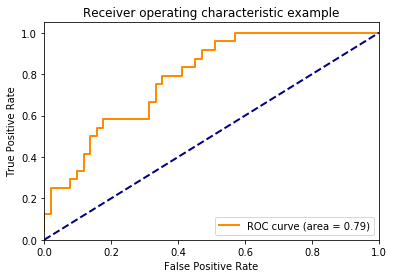

In [9]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()